In [2]:
TRAIN = 1
REBUILD_DATA = 1
REDEFINE_MODEL = 1

SUFFIX = 'cluster'

PATH_TRAIN = 'E:/EmotiW2017/lstm/original/Train_AFEW_' + SUFFIX
# PATH_TRAIN = 'E:/EmotiW2017/lstm/aligned_original/Train_AFEW'
PATH_VAL = 'E:/EmotiW2017/lstm/original/Val_AFEW'
# PATH_VAL = 'E:/EmotiW2017/lstm/aligned/Val_AFEW'

NPY_X_TRAIN_DATA = 'training_data_x_' + SUFFIX + '.npy'
NPY_Y_TRAIN_DATA = 'training_data_y_' + SUFFIX + '.npy'

NPY_X_TEST_DATA = 'testing_data_x_' + SUFFIX + '.npy'
NPY_Y_TEST_DATA = 'testing_data_y_' + SUFFIX + '.npy'

# NPY_X_TEST_DATA = 'testing_data_x_a.npy'
# NPY_Y_TEST_DATA = 'testing_data_y_a.npy'

MODEL_ARCH_FILE = 'cnn_lstm_afew2017_' + SUFFIX + '.json'
WEIGHT_FILE = 'cnn_lstm_afew2017_' + SUFFIX + '.hdf5'
TRAINING_HIST = 'cnn_lstm_afew2017_' + SUFFIX + '.pickle'

# We will process maxToAdd frames each video to recognize facial expression
maxToAdd = 16
size = 224

batch_size = 197
# batch_size = 32
n_epochs = 200

learning_rate = 0.0001
early_stop_after = 20

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import time
import json
import pickle

from tensorflow.contrib.keras.python.keras.datasets import mnist
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers.recurrent import SimpleRNN, LSTM, GRU
from tensorflow.contrib.keras.python.keras.optimizers import RMSprop, Adadelta, Adam
from tensorflow.contrib.keras.python.keras.layers import Convolution2D, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten
from tensorflow.contrib.keras.python.keras.layers.wrappers import TimeDistributed
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping
from tensorflow.contrib.keras.python.keras.regularizers import l1, l2
from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras import models

from tensorflow.contrib.keras.python.keras.models import model_from_json

from tensorflow.contrib.keras.python.keras import backend as K

from natsort import natsorted
from IPython.display import clear_output

# VGG-FACE
from tensorflow.contrib.keras.python.keras.preprocessing import image
from tensorflow.contrib.keras.python.keras.engine import Model
# from keras_vggface.vggface import VGGFace

# Confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

K.set_learning_phase(1)

In [4]:
def emo2int(emo):
    if emo == 'Angry':
        return 0
    elif emo == 'Disgust':
        return 1
    elif emo == 'Fear':
        return 2
    elif emo == 'Happy':
        return 3
    elif emo == 'Neutral':
        return 4
    elif emo == 'Sad':
        return 5
    else:
        return 6

In [106]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Training data

#### Count # of video in training data

In [5]:
if REBUILD_DATA == 1:
    n_vids_train = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                n_vids_train += 1

    print(' > %d videos found' % (n_vids_train))

#### Count # of frames in each video in training data

In [6]:
if REBUILD_DATA == 1:
    n_fra_stat_train = np.zeros((n_vids_train, 1))

    vid_indx = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid
                for fra in os.listdir(full_vid):
                    full_fra = full_vid + '/' + fra
                    if os.path.isfile(full_fra):
                        n_fra_stat_train[vid_indx, 0] += 1

                vid_indx += 1

    plt.hist(n_fra_stat_train, bins=60)
    plt.show()

In [7]:
if REBUILD_DATA == 1:
    print(np.average(n_fra_stat_train))
    print(stats.mode(n_fra_stat_train))

In [8]:
if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TRAIN_DATA) and os.path.isfile(NPY_Y_TRAIN_DATA):
    print('> loading training data...', end='')
    X_train = np.load(NPY_X_TRAIN_DATA)
    y_train = np.load(NPY_Y_TRAIN_DATA)
    print('done.')
else:
    print('> generating training data...', end='')
    X_train = []
    y_train = []

    X_train = np.zeros((n_vids_train, maxToAdd, size, size, 1))

    vid_indx = 0

    for emo in os.listdir(PATH_TRAIN):
        full_emo = PATH_TRAIN + '/' + emo
        if os.path.isdir(full_emo):
            for vid in os.listdir(full_emo):
                full_vid = full_emo + '/' + vid

                # Initialize a training example of max_num_time_steps, im_size, im_size
                output = np.zeros((maxToAdd, size, size, 1))

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((maxToAdd, n_fra_stat_train[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size))
                for fra in os.listdir(full_vid):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            img = img[:, :, 0]
                            example[fra_indx] = img

                            fra_indx += 1
                    else:
                        break

                output[0:numToAdd, :, :, 0] = example
                X_train[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_train.append(emo2int(emo))

                vid_indx += 1

    y_train = np.array(y_train)
    print('done.')

    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)

    plt.imshow(X_train[0, 0, :, :, 0], cmap='gray')
    plt.show()
    
    np.save(NPY_X_TRAIN_DATA, X_train)
    np.save(NPY_Y_TRAIN_DATA, y_train)

> loading training data...done.


# Validation data

In [9]:
n_vids_test = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            
            n_vids_test += 1

print(' > %d videos found' % (n_vids_test))

 > 383 videos found


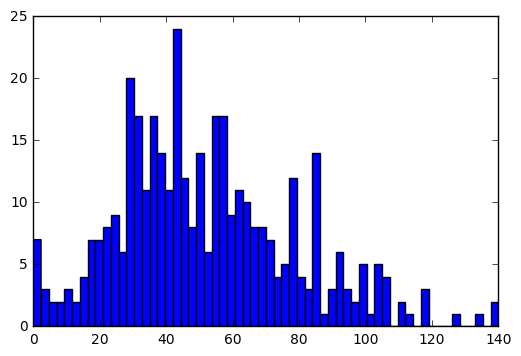

In [10]:
n_fra_stat_test = np.zeros((n_vids_test, 1))

vid_indx = 0

for emo in os.listdir(PATH_VAL):
    full_emo = PATH_VAL + '/' + emo
    if os.path.isdir(full_emo):
        for vid in os.listdir(full_emo):
            full_vid = full_emo + '/' + vid
            for fra in os.listdir(full_vid):
                full_fra = full_vid + '/' + fra
                if os.path.isfile(full_fra):
                    n_fra_stat_test[vid_indx, 0] += 1
                    
            vid_indx += 1

plt.hist(n_fra_stat_test, bins=60)
plt.show()

In [11]:
print(np.average(n_fra_stat_test))
print(stats.mode(n_fra_stat_test))

51.8825065274
ModeResult(mode=array([[ 54.]]), count=array([[11]]))


In [12]:
if REBUILD_DATA == 0 and os.path.isfile(NPY_X_TEST_DATA) and os.path.isfile(NPY_Y_TEST_DATA):
    print('> loading validation data...', end='')
    X_test = np.load(NPY_X_TEST_DATA)
    y_test = np.load(NPY_Y_TEST_DATA)
    print('done.')
else:
    print('> generating validation data...', end='')
    X_test = []
    y_test = []

    X_test = np.zeros((n_vids_test, maxToAdd, size, size, 1))

    vid_indx = 0

    for emo in natsorted(os.listdir(PATH_VAL)):
        full_emo = PATH_VAL + '/' + emo
        if os.path.isdir(full_emo):
            for vid in natsorted(os.listdir(full_emo)):
                full_vid = full_emo + '/' + vid

                # Initialize a testing example of max_num_time_steps, im_size, im_size
                output = np.zeros((maxToAdd, size, size, 1))

                # Decide how many images to put in that tensor
                numToAdd = int(np.min((maxToAdd, n_fra_stat_test[vid_indx, 0])))

                # Sample that images
                fra_indx = 0
                example = np.zeros((numToAdd, size, size))
                for fra in natsorted(os.listdir(full_vid)):
                    if fra_indx < numToAdd:
                        full_fra = full_vid + '/' + fra
                        if os.path.isfile(full_fra):
                            img = cv2.imread(full_fra)
                            img = cv2.resize(img, (size, size))
                            img = img[:, :, 0]
                            example[fra_indx] = img

                            fra_indx += 1
                    else:
                        break

                output[0:numToAdd, :, :, 0] = example
                X_test[vid_indx, :, :, :, :] = output

                # Get the label for current video
                y_test.append(emo2int(emo))

                vid_indx += 1

    y_test = np.array(y_test)
    print('done.')

    print("X_test shape: ", X_test.shape)
    print("y_test shape: ", y_test.shape)

    plt.imshow(X_test[0, 0, :, :, 0], cmap='gray')
    plt.show()
    
    np.save(NPY_X_TEST_DATA, X_test)
    np.save(NPY_Y_TEST_DATA, y_test)

> loading validation data...done.


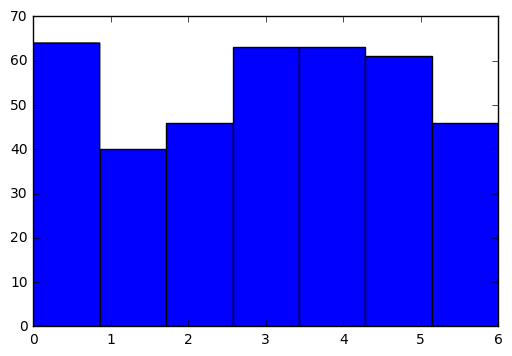

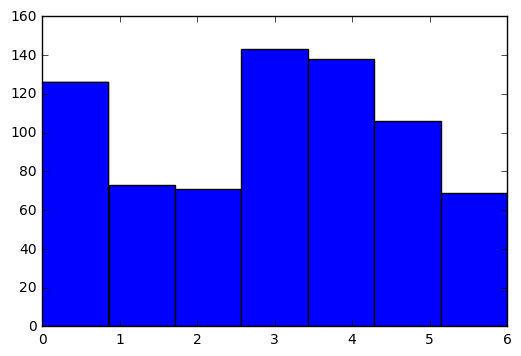

In [13]:
plt.hist(y_test, bins=7)
plt.show()

plt.hist(y_train, bins=7)
plt.show()

# CNN-LSTM

In [28]:
if os.path.isfile(MODEL_ARCH_FILE) and REDEFINE_MODEL == 0:
    print('Loading model...', end='')
    with open(MODEL_ARCH_FILE, 'r') as f:
        json_string = f.read()
    model = model_from_json(json_string)
    print('done.')
else:
    print('Defining model...', end='')

# 1111111111111111
#     # Define CNN-LSTM
#     model = Sequential()

#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='valid'), input_shape=(maxToAdd, size, size, 1)))

#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(16, (1, 1), activation='relu', padding='same')))

#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))

#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(16, (1, 1), activation='relu', padding='same')))
    
#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))

#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))

#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Conv2D(16, (1, 1), activation='relu', padding='same')))

#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
    
#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))
    
#     model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same')))

#     model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
#     model.add(TimeDistributed(Dropout(0.25)))

#     model.add(TimeDistributed(Flatten()))

#     model.add(Activation('relu'))

#     model.add(LSTM(units=1024, return_sequences=False, recurrent_dropout=0.25, kernel_regularizer=l2(0.001)))
#     # model.add(LSTM(units=512, return_sequences=True))
#     # model.add(LSTM(units=512, return_sequences=False))

#     # model.add(Dense(7, activation='softmax', kernel_regularizer=l2(0.001)))
#     model.add(Dense(7, activation='softmax'))

# # 22222222222222
#     model = Sequential()
#     model.add(TimeDistributed(Conv2D(8, (4, 4), padding='valid'), input_shape=(maxToAdd, size, size, 1)))
#     model.add(Activation('relu'))
#     model.add(TimeDistributed(Conv2D(16, (3, 3), padding='valid')))
#     model.add(Activation('relu'))
#     model.add(TimeDistributed(Flatten()))
#     model.add(Activation('relu'))
#     model.add(GRU(units=100, return_sequences=True))
#     model.add(GRU(units=50, return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(Dense(7, activation='softmax'))
    
    # VGG-FACE
    input_shape = (maxToAdd, 224, 224, 1)
    
    vgg_face = Sequential()

    # Block 1
    vgg_face.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False), input_shape=input_shape))
    vgg_face.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_2', trainable=False)))
    vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool1', trainable=False)))

    # Block 2
    vgg_face.add(TimeDistributed(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_1', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(128, (3, 3), activation='relu', padding='same', name='conv2_2', trainable=False)))
    vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool2', trainable=False)))

    # Block 3
    vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_1', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_2', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(256, (3, 3), activation='relu', padding='same', name='conv3_3', trainable=False)))
    vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool3', trainable=False)))

    # Block 4
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_1', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_2', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv4_3', trainable=False)))
    vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool4', trainable=False)))

    # Block 5
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_1', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_2', trainable=False)))
    vgg_face.add(TimeDistributed(Convolution2D(512, (3, 3), activation='relu', padding='same', name='conv5_3', trainable=False)))
    vgg_face.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2), name='pool5', trainable=False)))
    vgg_face.add(TimeDistributed(Flatten(name='output', trainable=False)))

    weights_path = 'rcmalli_vggface_tf_notop_v2.h5'
    vgg_face.load_weights(weights_path, by_name=True)
    
    x = vgg_face.output
    x = GRU(units=100, return_sequences=True, name='GRU_1')(x)
    x = GRU(units=50, return_sequences=False, name='GRU_2')(x)
    x = Dropout(0.2, name='dropout')(x)
    predictions = Dense(n_classes, activation='softmax', name='softmax')(x)
    
    model = Model(inputs=vgg_face.input, outputs=predictions)
    
    with open(MODEL_ARCH_FILE, 'w') as outfile:
        outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
    
    opt = Adam(lr=learning_rate)
    # opt = RMSprop(lr=learning_rate)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print(model.summary())
    
    print('done.')

Defining model..._________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_78_input (I (None, 16, 224, 224, 1)   0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 16, 224, 224, 64)  640       
_________________________________________________________________
time_distributed_79 (TimeDis (None, 16, 224, 224, 64)  36928     
_________________________________________________________________
time_distributed_80 (TimeDis (None, 16, 112, 112, 64)  0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 16, 112, 112, 128) 73856     
_________________________________________________________________
time_distributed_82 (TimeDis (None, 16, 112, 112, 128) 147584    
_________________________________________________________________
time_distributed_83 (TimeDis (None, 16, 56, 56, 128)   0   

In [29]:
if TRAIN == 1:
#     batch_size = 197
    batch_size = 4
    n_epochs = 500

    learning_rate = 0.0001
    early_stop_after = 100
    
    start_time = time.time()

    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_after, verbose=1)

    train_history = model.fit(X_train, y_train,
              validation_data=(X_test, y_test),
              shuffle=True, batch_size=batch_size, epochs=n_epochs, verbose=1,
              callbacks=[early_stopping])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

Train on 726 samples, validate on 383 samples
Epoch 1/500
726/726 [==============================] - 103s - loss: 1.9505 - acc: 0.1873 - val_loss: 1.9834 - val_acc: 0.1958
Epoch 2/500
726/726 [==============================] - 100s - loss: 1.9329 - acc: 0.1873 - val_loss: 2.0019 - val_acc: 0.1984
Epoch 3/500
726/726 [==============================] - 100s - loss: 1.9125 - acc: 0.2094 - val_loss: 2.0013 - val_acc: 0.1802
Epoch 4/500
726/726 [==============================] - 99s - loss: 1.9053 - acc: 0.2245 - val_loss: 1.9546 - val_acc: 0.2115
Epoch 5/500
726/726 [==============================] - 98s - loss: 1.8745 - acc: 0.2466 - val_loss: 1.9790 - val_acc: 0.2063
Epoch 6/500
726/726 [==============================] - 97s - loss: 1.8545 - acc: 0.2521 - val_loss: 1.9497 - val_acc: 0.2454
Epoch 7/500
726/726 [==============================] - 97s - loss: 1.8428 - acc: 0.2865 - val_loss: 2.0201 - val_acc: 0.1880
Epoch 8/500
726/726 [==============================] - 98s - loss: 1.8336 - 

726/726 [==============================] - 97s - loss: 0.2686 - acc: 0.9215 - val_loss: 3.3575 - val_acc: 0.2272
Epoch 66/500
726/726 [==============================] - 97s - loss: 0.3821 - acc: 0.8705 - val_loss: 3.2492 - val_acc: 0.2037
Epoch 67/500
726/726 [==============================] - 97s - loss: 0.2858 - acc: 0.9105 - val_loss: 3.4030 - val_acc: 0.2193
Epoch 68/500
726/726 [==============================] - 97s - loss: 0.2646 - acc: 0.9353 - val_loss: 3.6798 - val_acc: 0.2402
Epoch 69/500
726/726 [==============================] - 97s - loss: 0.2839 - acc: 0.9105 - val_loss: 3.4846 - val_acc: 0.2272
Epoch 70/500
726/726 [==============================] - 97s - loss: 0.2506 - acc: 0.9298 - val_loss: 3.4790 - val_acc: 0.2193
Epoch 71/500
726/726 [==============================] - 97s - loss: 0.2936 - acc: 0.9008 - val_loss: 3.4827 - val_acc: 0.2272
Epoch 72/500
726/726 [==============================] - 97s - loss: 0.1376 - acc: 0.9656 - val_loss: 3.6721 - val_acc: 0.2167
Epoch

In [30]:
if TRAIN == 1:
    # Save trained model
    model.save_weights(WEIGHT_FILE)    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(train_history.history, f)
        
    history_ = train_history.history
else:
    # Load trained model
    model.load_weights(WEIGHT_FILE)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)

In [31]:
# plot_model(model, to_file='model.png', show_shapes=True)

In [34]:
score = model.evaluate(X_train, y_train)
print('Train score:', score[0])
print('Train accuracy:', score[1])

score = model.evaluate(X_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

ResourceExhaustedError: OOM when allocating tensor with shape[512,224,224,64]
	 [[Node: time_distributed_78/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](time_distributed_78/Reshape, time_distributed_78/kernel/read)]]
	 [[Node: mul_53/_1599 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6_mul_53", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'time_distributed_78/convolution', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-47a1428c3771>", line 76, in <module>
    vgg_face.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu', padding='same', name='conv1_1', trainable=False), input_shape=input_shape))
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\models.py", line 463, in add
    layer(x)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\engine\topology.py", line 578, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\layers\wrappers.py", line 201, in call
    y = self.layer.call(inputs)  # (num_samples * timesteps, ...)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\layers\convolutional.py", line 178, in call
    dilation_rate=self.dilation_rate)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\contrib\keras\python\keras\backend.py", line 3046, in conv2d
    data_format='NHWC')
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 661, in convolution
    op=op)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 331, in with_space_to_batch
    return op(input, num_spatial_dims, padding)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 653, in op
    name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 129, in _non_atrous_convolution
    name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 403, in conv2d
    data_format=data_format, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[512,224,224,64]
	 [[Node: time_distributed_78/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](time_distributed_78/Reshape, time_distributed_78/kernel/read)]]
	 [[Node: mul_53/_1599 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_6_mul_53", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [50]:
# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

y_test
y_pred_ = model.predict(x=X_test, batch_size=batch_size, verbose=1)

383/383 [==============================] - 31s    


In [94]:
cm = confusion_matrix(y_test, y_pred)
cm = [cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]]
cm

[array([[ 0.23438,  0.07812,  0.15625,  0.14062,  0.17188,  0.14062,
          0.07812],
        [ 0.15   ,  0.1    ,  0.075  ,  0.15   ,  0.3    ,  0.15   ,  0.075  ],
        [ 0.28261,  0.1087 ,  0.19565,  0.15217,  0.1087 ,  0.13043,
          0.02174],
        [ 0.22222,  0.07937,  0.07937,  0.33333,  0.15873,  0.06349,
          0.06349],
        [ 0.30159,  0.06349,  0.07937,  0.09524,  0.25397,  0.15873,
          0.04762],
        [ 0.18033,  0.08197,  0.13115,  0.08197,  0.2459 ,  0.22951,
          0.04918],
        [ 0.19565,  0.13043,  0.13043,  0.06522,  0.21739,  0.17391,
          0.08696]])]

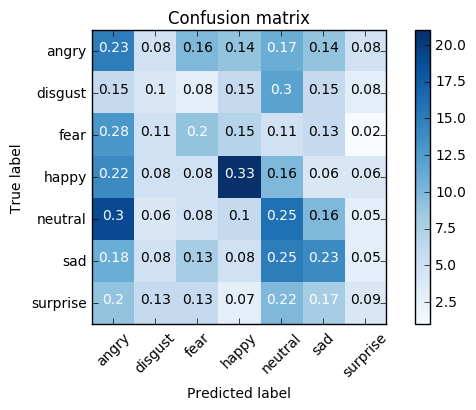

In [108]:
y_pred = np.argmax(y_pred_, axis=1)
# np.sum(y_pred == y_test)/y_test.shape[0]

plot_confusion_matrix(y_test=y_test, y_pred=y_pred,
                      classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')),
                      normalize=True)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


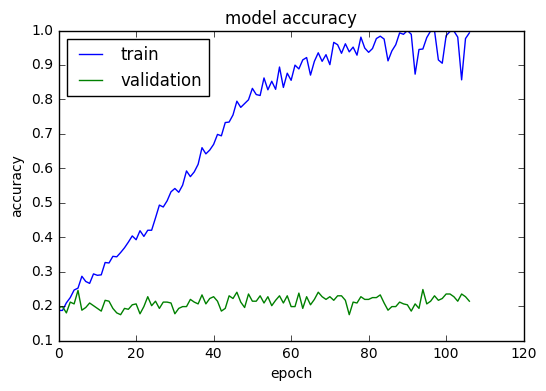

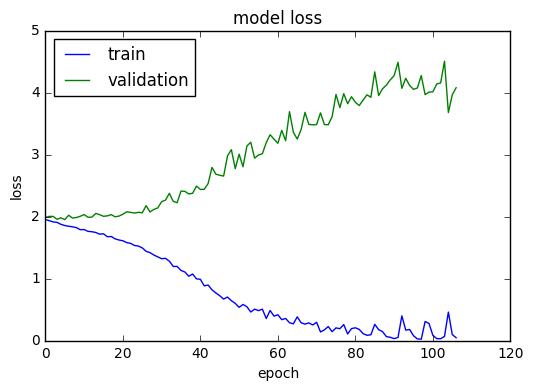

In [33]:
# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()